# 2. Сравнение моделей классификации

#### Импортирование необходимых библиотек

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split

#### Загрузка данных и первичная предобработка

In [2]:
df = pd.read_csv('all_embeddings_text.csv')
df_2 = pd.read_csv('all_embeddings_prep_text.csv')

df['1_prep_text'] = df_2['1_prep_text']
df['2_prep_text'] = df_2['2_prep_text']
df['3_prep_text'] = df_2['3_prep_text']

def parse_string_to_list(s):
    clean_s = s.strip('[]') 
    numbers = clean_s.split() 
    return [float(num) for num in numbers]

for i in range(1,4):
    df[f'{i}_text'] = df[f'{i}_text'].apply(parse_string_to_list)
    df[f'{i}_prep_text'] = df[f'{i}_prep_text'].apply(parse_string_to_list)

df['Label'] = df['Label'].astype(int)

embeddings_models = ['all_mpnet_base_v2', 'all_MiniLM_L6_v2', 'Universal-sentence-encoder']

#### Визуальный анализ распределения данных

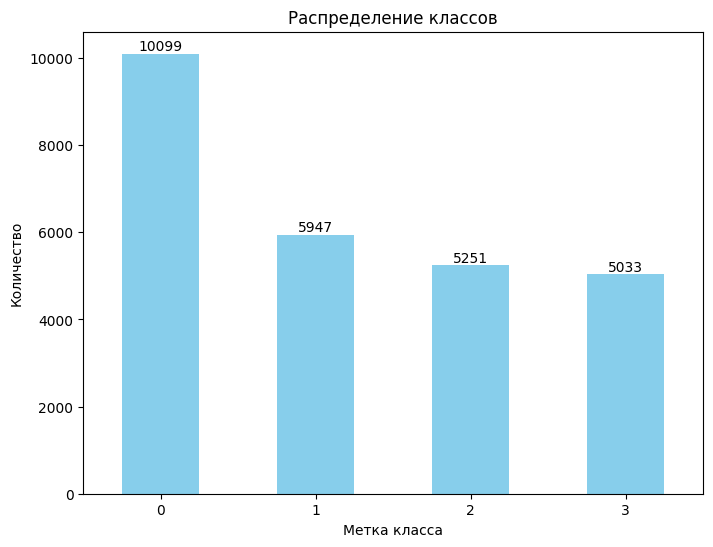

In [3]:
class_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение классов')
plt.xlabel('Метка класса')
plt.ylabel('Количество')
plt.xticks(rotation=0)  
for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom') 
plt.show()

#### Сравнение моделей LSTM

In [4]:
embeddings_models_list = []
classification_models = []
preprocessing_types = []
acc_list, precision_list, recall_list, f1_list = [], [], [], []

warnings.filterwarnings("ignore")
for i in range(1,4):
    for lstm_size in [64, 128, 256]:
            for prep_type in ['_text', '_prep_text']:

                print(f'Тип модели построения энбэдингов: {embeddings_models[i-1]}')
                print(f'Тип модели классификации: LSTM_{lstm_size}')

                embeddings_models_list.append(embeddings_models[i-1])
                classification_models.append(f'LSTM_{lstm_size}')
                
                X = np.array(df[f'{i}{prep_type}'].to_list())
                labels = np.array(df['Label'])  

                prep_type = 'yes' if prep_type == '_prep_text' else 'no'
                print(f'Наличие предобработки текста: {prep_type}')
                preprocessing_types.append(prep_type)

                X_train_val, X_test, y_train_val, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

                model = Sequential()
                model.add(Bidirectional(LSTM(lstm_size, input_shape=(1, X_train_val.shape[1]))))
                model.add(Dropout(0.5))
                model.add(Dense(4, activation='softmax'))  

                model.compile(loss='categorical_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy']) 

                y_train_val_categorical = to_categorical(y_train_val, num_classes=4)
                y_test_categorical = to_categorical(y_test, num_classes=4)

                n_splits = 4
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

                for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_train_val)):
                    print(f"Training fold {fold_idx + 1}/{n_splits}")

                    X_train = X_train_val[train_idx]
                    y_train = y_train_val_categorical[train_idx]
                    X_val = X_train_val[val_idx]
                    y_val = y_train_val_categorical[val_idx]

                    X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
                    X_val_lstm = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

                    early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)
                    model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs = 10, callbacks=[early_stopping])
                
                X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                y_pred_categorical = model.predict(X_test_lstm)
                y_pred = y_pred_categorical.argmax(axis=1)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='macro')
                recall = recall_score(y_test, y_pred, average='macro')
                f1 = f1_score(y_test, y_pred, average='macro')

                acc_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)

lstm_results = pd.DataFrame({'embeddings_model': embeddings_models_list,
                          'classification_model': classification_models,
                          'preprocessing_has': preprocessing_types,
                          'accuracy': acc_list,
                          'precision_macro': precision_list,
                          'recall_macro': recall_list,
                          'f1_macro': f1_list})

lstm_results.to_csv('lstm_results.csv')

Тип модели построения энбэдингов: all_mpnet_base_v2
Тип модели классификации: LSTM_64
Наличие предобработки текста: no
Training fold 1/4
Epoch 1/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8154 - loss: 0.6442 - val_accuracy: 0.9351 - val_loss: 0.2281
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9357 - loss: 0.2183 - val_accuracy: 0.9383 - val_loss: 0.2132
Epoch 3/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9448 - loss: 0.1968 - val_accuracy: 0.9406 - val_loss: 0.2046
Epoch 4/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9480 - loss: 0.1865 - val_accuracy: 0.9421 - val_loss: 0.2013
Epoch 5/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9484 - loss: 0.1815 - val_accuracy: 0.9406 - val_loss: 0.2007
Epoch 6/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9517 - loss: 0.1709 - val_accuracy: 0.9411 - val_loss: 0.1989
Epoch 7/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9542 - loss: 0.1635 - val_acc

In [5]:
lstm_results

,embeddings_model,classification_model,preprocessing_has,accuracy,precision_macro,recall_macro,f1_macro
0,all_mpnet_base_v2,LSTM_64,no,0.952146,0.953867,0.949392,0.951495
1,all_mpnet_base_v2,LSTM_64,yes,0.949297,0.950058,0.946428,0.948097
2,all_mpnet_base_v2,LSTM_128,no,0.950437,0.949691,0.949574,0.949617
3,all_mpnet_base_v2,LSTM_128,yes,0.950817,0.950404,0.949853,0.950122
4,all_mpnet_base_v2,LSTM_256,no,0.951196,0.949797,0.950774,0.950209
5,all_mpnet_base_v2,LSTM_256,yes,0.950627,0.950599,0.948875,0.949705
6,all_MiniLM_L6_v2,LSTM_64,no,0.944170,0.944847,0.942394,0.943491
7,all_MiniLM_L6_v2,LSTM_64,yes,0.940942,0.941138,0.939058,0.940035
8,all_MiniLM_L6_v2,LSTM_128,no,0.943411,0.943175,0.942090,0.942445
9,all_MiniLM_L6_v2,LSTM_128,yes,0.939992,0.940879,0.937730,0.939221


#### Сравнение моделей GRU

In [6]:
warnings.filterwarnings("ignore")

embeddings_models_list = []
classification_models = []
preprocessing_types = []
acc_list, precision_list, recall_list, f1_list = [], [], [], []

for i in range(1, 4):
    for gru_size in [64, 128, 256]:
        for prep_type in ['_text', '_prep_text']:
            print(f'Тип модели построения эмбеддингов: {embeddings_models[i-1]}')
            print(f'Тип модели классификации: GRU_{gru_size}')

            embeddings_models_list.append(embeddings_models[i-1])
            classification_models.append(f'GRU_{gru_size}')

            X = np.array(df[f'{i}{prep_type}'].to_list())
            labels = np.array(df['Label'])

            prep_type_label = 'yes' if prep_type == '_prep_text' else 'no'
            print(f'Наличие предобработки текста: {prep_type_label}')
            preprocessing_types.append(prep_type_label)

            X_train_val, X_test, y_train_val, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

            model = Sequential()
            model.add(Bidirectional(GRU(gru_size, input_shape=(1, X_train_val.shape[1]))))
            model.add(Dropout(0.5))
            model.add(Dense(4, activation='softmax'))  

            model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

            y_train_val_categorical = to_categorical(y_train_val, num_classes=4)
            y_test_categorical = to_categorical(y_test, num_classes=4)

            n_splits = 4
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_train_val)):
                print(f"Training fold {fold_idx + 1}/{n_splits}")

                X_train = X_train_val[train_idx]
                y_train = y_train_val_categorical[train_idx]
                X_val = X_train_val[val_idx]
                y_val = y_train_val_categorical[val_idx]

                X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
                X_val_gru = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

                early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
                model.fit(X_train_gru, y_train, validation_data=(X_val_gru, y_val), epochs=10, callbacks=[early_stopping])

            # Оценка модели на тестовой выборке
            X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
            y_pred_categorical = model.predict(X_test_gru)
            y_pred = y_pred_categorical.argmax(axis=1)

            # Вычисление метрик
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')

            acc_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

gru_results = pd.DataFrame({
    'embeddings_model': embeddings_models_list,
    'classification_model': classification_models,
    'preprocessing_has': preprocessing_types,
    'accuracy': acc_list,
    'precision_macro': precision_list,
    'recall_macro': recall_list,
    'f1_macro': f1_list
})

gru_results.to_csv('gru_results.csv')

Тип модели построения эмбеддингов: all_mpnet_base_v2
Тип модели классификации: GRU_64
Наличие предобработки текста: no
Training fold 1/4
Epoch 1/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8396 - loss: 0.5717 - val_accuracy: 0.9349 - val_loss: 0.2249
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9420 - loss: 0.2066 - val_accuracy: 0.9392 - val_loss: 0.2106
Epoch 3/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9466 - loss: 0.1893 - val_accuracy: 0.9413 - val_loss: 0.2044
Epoch 4/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9461 - loss: 0.1829 - val_accuracy: 0.9402 - val_loss: 0.2008
Epoch 5/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9496 - loss: 0.1704 - val_accuracy: 0.9402 - val_loss: 0.1983
Epoch 6/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9504 - loss: 0.1691 - val_accuracy: 0.9421 - val_loss: 0.1964
Epoch 7/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9527 - loss: 0.1579 - val_acc

In [7]:
gru_results

,embeddings_model,classification_model,preprocessing_has,accuracy,precision_macro,recall_macro,f1_macro
0,all_mpnet_base_v2,GRU_64,no,0.950817,0.951614,0.948338,0.949903
1,all_mpnet_base_v2,GRU_64,yes,0.949487,0.949299,0.948073,0.948645
2,all_mpnet_base_v2,GRU_128,no,0.948348,0.950776,0.944785,0.947608
3,all_mpnet_base_v2,GRU_128,yes,0.948538,0.949117,0.946375,0.947703
4,all_mpnet_base_v2,GRU_256,no,0.950247,0.951382,0.947506,0.949357
5,all_mpnet_base_v2,GRU_256,yes,0.948728,0.949921,0.945715,0.947753
6,all_MiniLM_L6_v2,GRU_64,no,0.942651,0.943359,0.941018,0.941978
7,all_MiniLM_L6_v2,GRU_64,yes,0.938283,0.937284,0.937866,0.937493
8,all_MiniLM_L6_v2,GRU_128,no,0.941701,0.944137,0.938008,0.940793
9,all_MiniLM_L6_v2,GRU_128,yes,0.942081,0.944377,0.938077,0.941039


#### Сравнение моделей Perceptron

In [4]:
warnings.filterwarnings("ignore")

embeddings_models_list = []
classification_models = []
preprocessing_types = []
acc_list, precision_list, recall_list, f1_list = [], [], [], []

num_classes = 4  

for i in range(1, 4):
    for layer_size in [64, 128, 256, 512]:
        for prep_type in ['_text', '_prep_text']:
            print(f'Тип модели построения эмбеддингов: {embeddings_models[i-1]}')
            print(f'Тип модели классификации: Perceptron_{layer_size}')

            embeddings_models_list.append(embeddings_models[i-1])
            classification_models.append(f'Perceptron_{layer_size}')

            X = np.array(df[f'{i}{prep_type}'].to_list())
            labels = np.array(df['Label'])

            prep_type_label = 'yes' if prep_type == '_prep_text' else 'no'
            print(f'Наличие предобработки текста: {prep_type_label}')
            preprocessing_types.append(prep_type_label)

            X_train_val, X_test, y_train_val, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

            n_features = len(X_train_val[0])

            model = Sequential()
            model.add(Dense(layer_size, input_shape=(n_features,)))
            model.add(Activation('relu'))
            model.add(Dropout(0.5))
            model.add(Dense(4, activation='softmax'))  

            model.compile(loss='categorical_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'])

            y_train_val_categorical = to_categorical(y_train_val, num_classes=num_classes)
            y_test_categorical = to_categorical(y_test, num_classes=num_classes)

            n_splits = 4
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_train_val)):
                print(f"Training fold {fold_idx + 1}/{n_splits}")

                X_train = X_train_val[train_idx]
                y_train = y_train_val_categorical[train_idx]
                X_val = X_train_val[val_idx]
                y_val = y_train_val_categorical[val_idx]

                early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
                model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[early_stopping])


            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)

            # Вычисление метрик
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')

            acc_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

perceptron_results = pd.DataFrame({
    'embeddings_model': embeddings_models_list,
    'classification_model': classification_models,
    'preprocessing_has': preprocessing_types,
    'accuracy': acc_list,
    'precision_macro': precision_list,
    'recall_macro': recall_list,
    'f1_macro': f1_list
})

perceptron_results.to_csv('perceptron_results.csv')

Тип модели построения эмбеддингов: all_mpnet_base_v2
Тип модели классификации: Perceptron_64
Наличие предобработки текста: no
Training fold 1/4
Epoch 1/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8057 - loss: 0.6565 - val_accuracy: 0.9349 - val_loss: 0.2351
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.9339 - loss: 0.2431 - val_accuracy: 0.9383 - val_loss: 0.2164
Epoch 3/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9444 - loss: 0.2030 - val_accuracy: 0.9394 - val_loss: 0.2054
Epoch 4/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.9479 - loss: 0.1942 - val_accuracy: 0.9394 - val_loss: 0.2010
Epoch 5/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9510 - loss: 0.1822 - val_accuracy: 0.9396 - val_loss: 0.1993
Epoch 6/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.9512 - loss: 0.1774 - val_accuracy: 0.9425 - val_loss: 0.1924
Epoch 7/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9532 - loss:

In [5]:
perceptron_results

,embeddings_model,classification_model,preprocessing_has,accuracy,precision_macro,recall_macro,f1_macro
0,all_mpnet_base_v2,Perceptron_64,no,0.952716,0.953844,0.950604,0.952126
1,all_mpnet_base_v2,Perceptron_64,yes,0.950817,0.950440,0.949388,0.949839
2,all_mpnet_base_v2,Perceptron_128,no,0.952336,0.951820,0.951719,0.951746
3,all_mpnet_base_v2,Perceptron_128,yes,0.952146,0.951854,0.950533,0.951142
4,all_mpnet_base_v2,Perceptron_256,no,0.955564,0.956242,0.953391,0.954723
5,all_mpnet_base_v2,Perceptron_256,yes,0.953855,0.953861,0.952301,0.953045
6,all_mpnet_base_v2,Perceptron_512,no,0.957653,0.957687,0.956161,0.956849
7,all_mpnet_base_v2,Perceptron_512,yes,0.954425,0.953636,0.953000,0.953307
8,all_MiniLM_L6_v2,Perceptron_64,no,0.946449,0.947600,0.944073,0.945732
9,all_MiniLM_L6_v2,Perceptron_64,yes,0.940182,0.940151,0.939180,0.939510


#### Формирование общей таблицы с результатами

In [6]:
res_1 = pd.read_csv('lstm_results.csv')
res_2 = pd.read_csv('gru_results.csv')
res_3 = pd.read_csv('perceptron_results.csv')

merged_df = pd.concat([res_1, res_2, res_3], ignore_index=True)
sorted_df = merged_df.sort_values(by='f1_macro', ascending=False, ignore_index=True)
sorted_df = sorted_df.iloc[:,1:]
sorted_df[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']] = sorted_df[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']].round(5)

def color_gradient(value, min_value, max_value):
    norm_value = (value - min_value) / (max_value - min_value)
    palette = sns.color_palette("light:#5A9", as_cmap=True)
    rgb = palette(norm_value)
    color = f'background-color: rgb({int(rgb[0]*250)}, {int(rgb[1]*250)}, {int(rgb[2]*250)})'
    return color

sorted_df_styled = sorted_df.style.apply(lambda x: [color_gradient(v, sorted_df['f1_macro'].min(), sorted_df['f1_macro'].max()) if x.name == 'f1_macro' else '' for v in x], axis=0)

sorted_df_styled.set_table_styles([
    {'selector': 'table', 'props': [('border', '1px solid #cccccc')]},
    {'selector': 'th', 'props': [('border', '1px solid #cccccc'), ('background-color', '#f2f2f2'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('border', '1px solid #cccccc'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#ffffff')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},
])

sorted_df_styled

sorted_df_styled.to_html('results.html')